# CAPSTONE PROJECT - IMAGE CLASSIFIER
MIKHAIL ZHIGAREV<BR> 
MAY 2017

## INTRO
The purpose of this notebook is to implement image classification on real world problem. 
In this notebook, we will cover local preprocessing, training, prediction and evaluation. We started from data in GCS in csv form plus images; used transfer learning for very fast training and then used BigQuery for model performance analysis.


## PROJECT SETUP
In this section we'll get all the data we need in readable format, setup our working environment. The project is set up on Google Cloud Platform<sup>1</sup> and leverages Cloud Datalab<sup>2</sup>. Cloud Datalab is an interactive tool created to explore, analyze, visualize data and build machine learning models. The tool is built on Jupyter<sup>3</sup>. To make the project running in Google Cloud, follow the instruction in **README** file.

### Getting the data
We've collected images for the project using a mix of YouTube Data API, OpenCV and Cloud Datalab. Find our more in **GetFiles.ipynb**. According to Google's support pages, GCS will be a bit slower if we connect them with Datalab, so we moved the directory of images from GCS into Datalab environment to get higher speed.

In [ ]:
# create our main folder
# !mkdir -p /content/excel-word-classifier-tt/

In [ ]:
# copy content from the bucket to the local folder
# !gsutil -m cp -r dir gs://excel-word-classifier-tt/ /content/

### Folder structure
The folder structure for the train/test data looks like this:

```python
    excel-word-classifier-tt/
        train/
            word_mac_2017_1.jpg
            word_mac_2017_2.jpg
            ...
            excel_mac_2017_1.jpg
            excel_mac_2017_2.jpg
            ...
        test/
            word_mac_2017_421.jpg
            word_mac_2017_234.jpg
            ...
            excel_mac_2017_1.jpg
            excel_mac_2017_2.jpg
            ...
        csv/
            all.csv
            test.csv
            train.csv
```
### Files
CSV folder contains names and labels for each screenshot, for example word_mac_2017_1.jpg (name), word (label). We used this format to describe our pictures **word_mac_2017_1.jpg**, where:
<ul>
  <li>word - software name</li>
  <li>mac - platform name</li>
  <li>2017 - version name</li>
  <li>1 - screenshot number</li>
</ul>
<br>
Although the dataset could skew our analysis, but I believe it's a good start in our exploration journey. After getting hands-on experience with new libraries and techniques will provide ideas for futher steps to improve our classification.

### Import libs
We will be using Google's Machine Learning toolbox and Google Datalab for this project

In [1]:
import mltoolbox.image.classification as model
from google.datalab.ml import *

### Define paths
First of all, let's define additional directories we need for the project:
<ul>
  <li>local_train_file and local_eval_file - links to the training and testing csv file</li>
  <li>worker_dir - main directory where we store key files and folders</li>
  <li>preprocessed_dir - directory where we'll be keeping smaller versions of the pictures </li>
  <li>model_dir - directory with the trained model</li>
  <li>prediction_dir - directory for prediction</li>
</ul>

In [2]:
local_train_file = '/content/excel-word-classifier-tt/csv/train.csv'
local_eval_file = '/content/excel-word-classifier-tt/csv/test.csv'
worker_dir = '/content/excel-word-classifier-tt/'
preprocessed_dir = worker_dir + '/runlocal'
model_dir = worker_dir + '/tinymodellocal'
prediction_dir = worker_dir + '/modelevallocal'

### Prepare the data
Our images are just to big, so we need to reprocess them in order to get the model built fast. We preprocess images using standard Google DataFlow pipeline in order to convert the image format, resize images, and run the converted image through a pre-trained model to get the features or embeddings. 

In [3]:
train_set = CsvDataSet(local_train_file, schema='image_url:STRING,label:STRING')
model.preprocess(train_set, preprocessed_dir)

## THE MODEL
<br>
### The inception model
Image classification models (pre-trained Deep Neural Networks) are openly available for general public. One of them is called the Inception v3. The Inception v3 model takes a lot of time to train even on super computers, so it is impossible to build it on an ordinary lapton or just using GCP (too expensive). 
![inception](https://4.bp.blogspot.com/-TMOLlkJBxms/Vt3HQXpE2cI/AAAAAAAAA8E/7X7XRFOY6Xo/s1600/image03.png)
Unfortunately, the Inception model has its limitations. It can't help us with recognizing some categories like people. This may be due to the training-set that was used.

<br>
### Transfer learning
Luckily, we are able to implement the pre-trained Inception model and get the highly accurate models for other labels. All we need is to  replace the layer that does the final classification. This is called Transfer Learning. Transfer learning retains most of the inception model, consequently we don't need to invest a lot of time and money in building our own model.
![transfer](https://cloud.google.com/blog/big-data/2016/12/images/148114735559140/image-classification-3.png)
Hence, the next step is to train the inception model with the preprocessed images using transfer learning. 


### Train the model
We will be using a single label image classification solution and then will use the output for batch prediction

In [5]:
import logging
logging.getLogger().setLevel(logging.INFO)
model.train(preprocessed_dir, 30, 800, model_dir)
logging.getLogger().setLevel(logging.WARNING)

In [6]:
batch_size = [10, 30, 60, 120]
max_steps = [400, 800, 1600]

for i in batch_size:
  for j in max_steps:
    logging.getLogger().setLevel(logging.INFO)
    print " ====== batch_size: "+str(i)+" ====== max_steps: "+str(j)+" ======"
    model.train(preprocessed_dir, i, j, model_dir+"/models/"+str(i)+str(j))
    logging.getLogger().setLevel(logging.WARNING)

 ====== batch_size: 10 ====== max_steps: 400 ======
INFO:tensorflow:global_step/sec: 0


INFO:root:Train [master/0], step 401 (0.108 sec) 3708.8 global steps/s, 9.2 local steps/s
INFO:root:Eval, step 401:
- on train set loss: 0.083, accuracy: 0.975
-- on eval set loss: 0.079, accuracy: 0.978
INFO:root:Eval, step 401:
- on train set loss: 0.083, accuracy: 0.975
-- on eval set loss: 0.079, accuracy: 0.978
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/10400/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/10400/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/10400/model/saved_model.pb


completed
 ====== batch_size: 10 ====== max_steps: 800 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.093 sec) 10.8 global steps/s, 10.8 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.667, accuracy: 0.552
-- on eval set loss: 0.668, accuracy: 0.552
INFO:root:Eval, step 800:
- on train set loss: 0.008, accuracy: 0.998
-- on eval set loss: 0.014, accuracy: 0.993
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/10800/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/10800/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/10800/model/saved_model.pb


completed
 ====== batch_size: 10 ====== max_steps: 1600 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.089 sec) 11.3 global steps/s, 11.3 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.866, accuracy: 0.496
-- on eval set loss: 0.855, accuracy: 0.510
INFO:root:Train [master/0], step 1356 (17.173 sec) 79.3 global steps/s, 79.3 local steps/s
INFO:root:Eval, step 1600:
- on train set loss: 0.009, accuracy: 0.996
-- on eval set loss: 0.025, accuracy: 0.992
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/101600/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/101600/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/101600/model/saved_model.pb


completed
 ====== batch_size: 30 ====== max_steps: 400 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.081 sec) 12.3 global steps/s, 12.3 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.746, accuracy: 0.685
-- on eval set loss: 0.756, accuracy: 0.683
INFO:root:Eval, step 400:
- on train set loss: 0.019, accuracy: 0.993
-- on eval set loss: 0.027, accuracy: 0.993
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/30400/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/30400/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/30400/model/saved_model.pb


completed
 ====== batch_size: 30 ====== max_steps: 800 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.095 sec) 10.6 global steps/s, 10.6 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.746, accuracy: 0.503
-- on eval set loss: 0.742, accuracy: 0.517
INFO:root:Eval, step 800:
- on train set loss: 0.002, accuracy: 1.000
-- on eval set loss: 0.009, accuracy: 0.997
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/30800/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/30800/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/30800/model/saved_model.pb


completed
 ====== batch_size: 30 ====== max_steps: 1600 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.094 sec) 10.6 global steps/s, 10.6 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.717, accuracy: 0.575
-- on eval set loss: 0.733, accuracy: 0.557
INFO:root:Train [master/0], step 1127 (16.983 sec) 66.7 global steps/s, 66.7 local steps/s
INFO:root:Eval, step 1600:
- on train set loss: 0.001, accuracy: 1.000
-- on eval set loss: 0.008, accuracy: 0.998
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/301600/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/301600/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/301600/model/saved_model.pb


completed
 ====== batch_size: 60 ====== max_steps: 400 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.095 sec) 10.5 global steps/s, 10.5 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.635, accuracy: 0.835
-- on eval set loss: 0.637, accuracy: 0.798
INFO:root:Eval, step 400:
- on train set loss: 0.005, accuracy: 0.999
-- on eval set loss: 0.012, accuracy: 0.995
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/60400/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/60400/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/60400/model/saved_model.pb


completed
 ====== batch_size: 60 ====== max_steps: 800 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.090 sec) 11.1 global steps/s, 11.1 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.676, accuracy: 0.783
-- on eval set loss: 0.670, accuracy: 0.800
INFO:root:Eval, step 800:
- on train set loss: 0.002, accuracy: 1.000
-- on eval set loss: 0.009, accuracy: 0.997
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/60800/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/60800/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/60800/model/saved_model.pb


completed
 ====== batch_size: 60 ====== max_steps: 1600 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.103 sec) 9.7 global steps/s, 9.7 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.609, accuracy: 0.820
-- on eval set loss: 0.618, accuracy: 0.792
INFO:root:Train [master/0], step 828 (16.911 sec) 49.2 global steps/s, 49.2 local steps/s
INFO:root:Train [master/0], step 1533 (31.919 sec) 47.0 global steps/s, 47.0 local steps/s
INFO:root:Eval, step 1533:
- on train set loss: 0.000, accuracy: 1.000
-- on eval set loss: 0.007, accuracy: 0.997
INFO:root:Eval, step 1600:
- on train set loss: 0.000, accuracy: 1.000
-- on eval set loss: 0.008, accuracy: 0.998
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/601600/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/601600/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/601600/model/saved_model.pb


completed
 ====== batch_size: 120 ====== max_steps: 400 ======
INFO:tensorflow:global_step/sec: 0


INFO:tensorflow:global_step/sec: 0
INFO:root:Train [master/0], step 1 (0.119 sec) 8.4 global steps/s, 8.4 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.638, accuracy: 0.855
-- on eval set loss: 0.642, accuracy: 0.840
INFO:root:Eval, step 400:
- on train set loss: 0.005, accuracy: 0.998
-- on eval set loss: 0.012, accuracy: 0.995
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/120400/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/120400/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/120400/model/saved_model.pb


completed
 ====== batch_size: 120 ====== max_steps: 800 ======


INFO:root:Train [master/0], step 1 (0.104 sec) 9.6 global steps/s, 9.6 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.695, accuracy: 0.581
-- on eval set loss: 0.683, accuracy: 0.588
INFO:root:Train [master/0], step 526 (16.922 sec) 31.2 global steps/s, 31.2 local steps/s
INFO:root:Eval, step 800:
- on train set loss: 0.001, accuracy: 1.000
-- on eval set loss: 0.008, accuracy: 0.998
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/120800/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/120800/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/120800/model/saved_model.pb


completed
 ====== batch_size: 120 ====== max_steps: 1600 ======


INFO:root:Train [master/0], step 1 (0.115 sec) 8.7 global steps/s, 8.7 local steps/s
INFO:root:Eval, step 1:
- on train set loss: 0.585, accuracy: 0.859
-- on eval set loss: 0.601, accuracy: 0.840
INFO:root:Train [master/0], step 543 (17.562 sec) 31.1 global steps/s, 31.1 local steps/s
INFO:root:Train [master/0], step 1000 (32.595 sec) 30.4 global steps/s, 30.4 local steps/s
INFO:root:Eval, step 1000:
- on train set loss: 0.001, accuracy: 1.000
-- on eval set loss: 0.008, accuracy: 0.998
INFO:root:Train [master/0], step 1443 (49.666 sec) 25.9 global steps/s, 25.9 local steps/s
INFO:root:Eval, step 1600:
- on train set loss: 0.000, accuracy: 1.000
-- on eval set loss: 0.007, accuracy: 0.998
INFO:root:Exporting prediction graph to /content/excel-word-classifier-tt//tinymodellocal/models/1201600/model


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to save.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/1201600/model/saved_model.pb


INFO:tensorflow:SavedModel written to: /content/excel-word-classifier-tt//tinymodellocal/models/1201600/model/saved_model.pb


completed


### Visualize the training
Let's run TensorBoard to visualize the completed training and use the best model

In [4]:
model_dir = "/content/excel-word-classifier-tt//tinymodellocal/models/1201600/"
tb_id = TensorBoard.start(model_dir)

Graph visualization
![transfer](http://i.imgur.com/b1PCtLE.png)

We see that model's accuracy increasing and loss goes down:
![accuracy](http://i.imgur.com/HEyMZBa.png)
![loss](http://i.imgur.com/Aos9Aql.png)

## PREDICT
Let's start with a quick check by taking a couple of images and using the model to predict the software

Predicting...


word(0.99996)

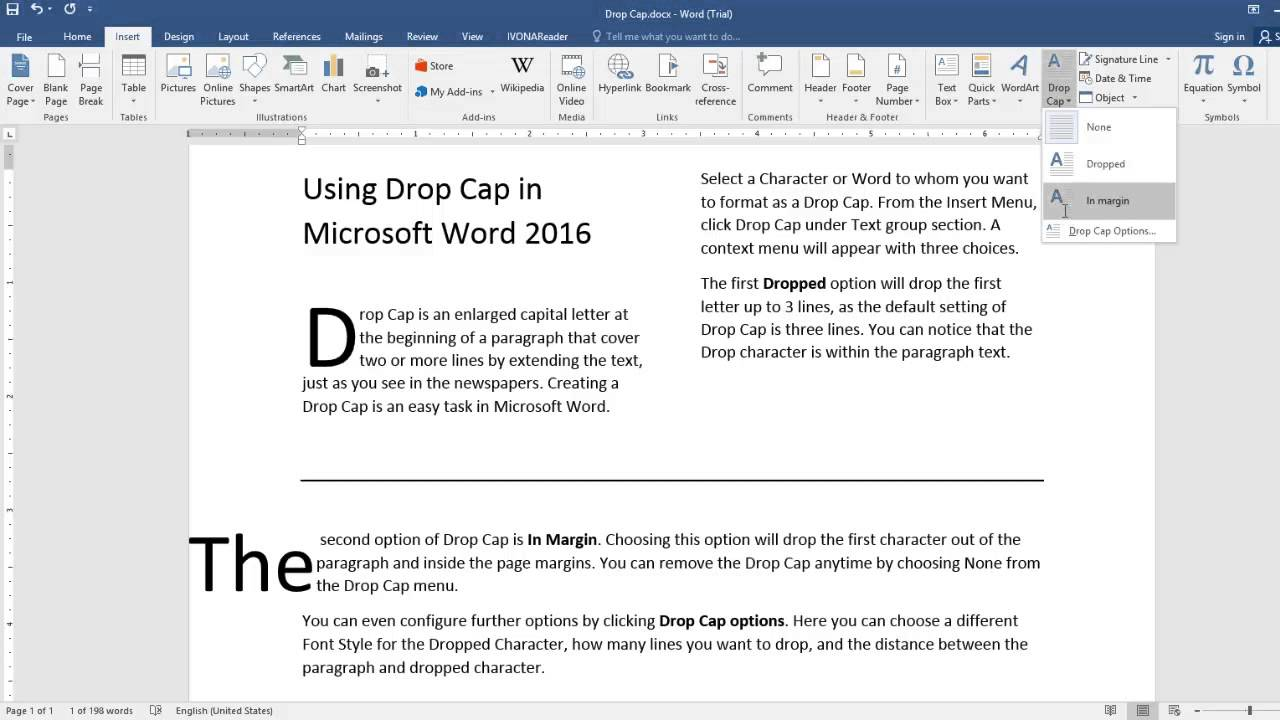

excel(0.99998)

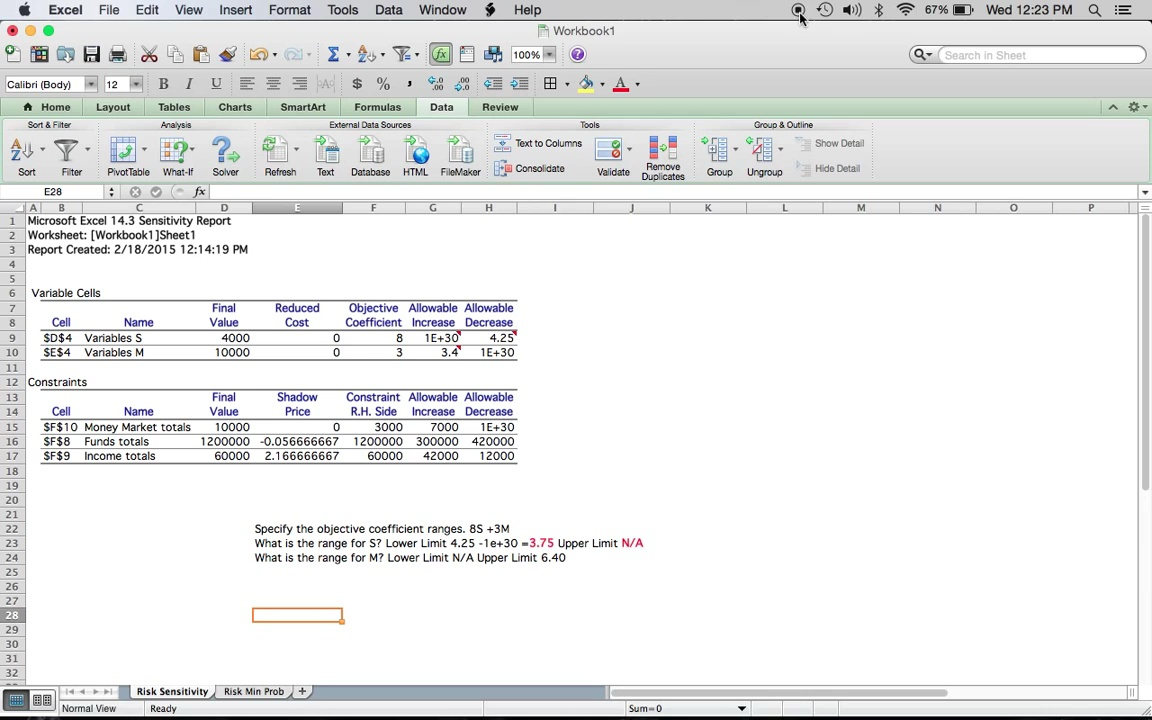

,image_url,label,score
0,/content/excel-word-classifier-tt/test/word_wi...,word,0.99996
1,/content/excel-word-classifier-tt/test/excel_m...,excel,0.99998


In [5]:
images = ['/content/excel-word-classifier-tt/test/word_win_2017_771.jpg',
          '/content/excel-word-classifier-tt/test/excel_mac_2011_560.jpg']


model.predict(model_dir, images, show_image=True)

We see, that the model predicted correct label for both pictures. Unfortunately, it might be misleading.

We assumed from the beginning that we'll be able to get pretty clean data from the uploaded videos. In this scenario we can count on the model. But what will happen if we've get screenshot? Variation here is much broader by default. Let's make some additional tests on new data we've collected using Google Image Search.

In [ ]:
import glob
images = glob.glob('/content/ad_test/*')

model.predict(model_dir, images, show_image=True)

Predicting...


It looks like the model can make accurate preditions on some examples, but we need to evaluate the model against a much larger dataset. 

## EVALUATION
<br>
### Test the model
We did a quick test of the model using a few samples. Let's check the model on the testing set.

In [10]:
import google.datalab.bigquery as bq
bq.Dataset('software').create()

Dataset granula-165104.software

In [11]:
eval_set = CsvDataSet(local_eval_file, schema='image_url:STRING,label:STRING')
model.batch_predict(eval_set, model_dir, output_bq_table='software.eval_results_local')

completed


### Errors

We've exported the results and prediction results in a BigQuery table. Let's evaluate errors.
![loss](/content/ad_test/ad_test_1.jpg)

In [12]:
%%bq query --name wrong_prediction

SELECT * FROM software.eval_results_local where target != predicted

In [18]:
result = wrong_prediction.execute().result()
images = result.to_dataframe()
images

,image_url,target,predicted,target_prob,predicted_prob
0,/content/excel-word-classifier-tt/test/excel_m...,excel,word,0.492637,0.506855
1,/content/excel-word-classifier-tt/test/excel_w...,excel,word,0.082483,0.917299
2,/content/excel-word-classifier-tt/test/excel_w...,excel,word,0.013613,0.986340
3,/content/excel-word-classifier-tt/test/excel_m...,excel,word,0.368282,0.631552
4,/content/excel-word-classifier-tt/test/excel_w...,excel,word,0.330498,0.669409
5,/content/excel-word-classifier-tt/test/excel_w...,excel,word,0.193987,0.805839
6,/content/excel-word-classifier-tt/test/excel_w...,excel,word,0.127347,0.872399
7,/content/excel-word-classifier-tt/test/excel_w...,excel,word,0.071892,0.928051
8,/content/excel-word-classifier-tt/test/excel_w...,excel,word,0.475442,0.524360
9,/content/excel-word-classifier-tt/test/excel_w...,excel,word,0.054143,0.945664


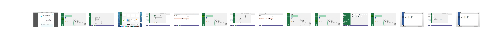

In [23]:
from IPython.core.display import Image, display

for i in images['image_url']:
  display(Image(filename=str(i), width=100))

Confusion matrix is a common way of comparing the confusion of the model - aggregate data about where the actual result did not match the expected result.

In [ ]:
ConfusionMatrix.from_bigquery('software.eval_results_local').plot()

More advanced analysis can be done using the feature slice view. For the feature slice view, let's define SQL queries that compute accuracy and log loss and then use the metrics.

In [ ]:
%%bq query --name accuracy

SELECT
  target,
  SUM(CASE WHEN target=predicted THEN 1 ELSE 0 END) as correct,
  COUNT(*) as total,
  SUM(CASE WHEN target=predicted THEN 1 ELSE 0 END)/COUNT(*) as accuracy
FROM
  software.eval_results_local
GROUP BY
  target

In [ ]:
accuracy.execute().result()

In [ ]:
%%bq query --name logloss

SELECT feature, AVG(-logloss) as logloss, count(*) as count FROM
(
SELECT feature, CASE WHEN correct=1 THEN LOG(prob) ELSE LOG(1-prob) END as logloss
FROM
(
SELECT
target as feature, 
CASE WHEN target=predicted THEN 1 ELSE 0 END as correct,
target_prob as prob
FROM software.eval_results_local))
GROUP BY feature

In [ ]:
FeatureSliceView().plot(logloss)

## APPENDIX
<br>
### Refferences
<ol>
<li>Google Cloud Platform - https://cloud.google.com/</li>
<li>Google Cloud Datalab - https://cloud.google.com/datalab/</li>
<li>Jupyter Notebook - http://jupyter.org</li>
<li>Rethinking the Inception Architecture for Computer Vision - https://arxiv.org/abs/1512.00567</li>
</ol>

### Clean up

In [ ]:
# import shutil
# shutil.rmtree("/content/excel-word-classifier-tt/")

# import google.datalab.bigquery as bq
# bq.Table('software.eval_results_local').delete()

# TensorBoard.stop(tb_id)